In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
! unzip /content/drive/MyDrive/DUTS-TR

Streaming output truncated to the last 5000 lines.
 extracting: DUTS-TR/DUTS-TR-Mask/n07718747_3382.png  
  inflating: DUTS-TR/DUTS-TR-Mask/n04270147_12691.png  
 extracting: DUTS-TR/DUTS-TR-Mask/n03211117_3402.png  
 extracting: DUTS-TR/DUTS-TR-Mask/ILSVRC2012_test_00000680.png  
  inflating: DUTS-TR/DUTS-TR-Mask/ILSVRC2012_val_00036949.png  
  inflating: DUTS-TR/DUTS-TR-Mask/ILSVRC2014_train_00033735.png  
  inflating: DUTS-TR/DUTS-TR-Mask/n01644900_4125.png  
  inflating: DUTS-TR/DUTS-TR-Mask/n04540053_2438.png  
  inflating: DUTS-TR/DUTS-TR-Mask/n03770439_7684.png  
  inflating: DUTS-TR/DUTS-TR-Mask/n07873807_5318.png  
  inflating: DUTS-TR/DUTS-TR-Mask/ILSVRC2014_train_00010870.png  
  inflating: DUTS-TR/DUTS-TR-Mask/n03764736_1884.png  
  inflating: DUTS-TR/DUTS-TR-Mask/n07742313_494.png  
 extracting: DUTS-TR/DUTS-TR-Mask/n03770439_218.png  
  inflating: DUTS-TR/DUTS-TR-Mask/ILSVRC2013_test_00009085.png  
  inflating: DUTS-TR/DUTS-TR-Mask/ILSVRC2012_test_00000909.png  
 extracti

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import cv2
import os
import splitfolders
import glob
import random
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm 
from keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from skimage.transform import resize
from skimage.io import imread, imshow
from PIL import Image
from skimage.io._plugins.pil_plugin import ndarray_to_pil, pil_to_ndarray


In [ ]:

import splitfolders

input_folder = '/content/DUTS-TR'


splitfolders.ratio(input_folder, output='/content/DUTS-TR', 
                   seed=42, ratio=(.7, .1, .2), 
                   group_prefix=None)

Copying files: 21106 files [00:03, 6565.58 files/s]


In [ ]:
train_images_path = '/content/DUTS-TR/train/DUTS-TR-Image'
val_images_path='/content/DUTS-TR/val/DUTS-TR-Image'
test_images_path='/content/DUTS-TR/test/DUTS-TR-Image'
train_mask_path = '/content/DUTS-TR/train/DUTS-TR-Mask'
val_mask_path='/content/DUTS-TR/val/DUTS-TR-Mask'
test_mask_path='/content/DUTS-TR/test/DUTS-TR-Mask'

IMG_HEIGHT=128
IMG_WIDTH= 128
IMG_CHANNELS=3



In [ ]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='aam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
checkpointer=tf.keras.callbacks.ModelCheckpoint('Model.h5',verbose=1, save_best_only=True)
callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'), tf.keras.callbacks.TensorBoard(log_dir='/content/logs')]

In [ ]:
train_ids=sorted(next(os.walk(train_images_path))[2])
test_ids=sorted(next(os.walk(test_images_path))[2])
train_mask_ids=sorted(next(os.walk(train_mask_path))[2])
test_mask_ids=sorted(next(os.walk(test_mask_path))[2])
print(train_ids)
print(train_mask_ids)

['ILSVRC2012_test_00000004.jpg', 'ILSVRC2012_test_00000018.jpg', 'ILSVRC2012_test_00000019.jpg', 'ILSVRC2012_test_00000022.jpg', 'ILSVRC2012_test_00000030.jpg', 'ILSVRC2012_test_00000072.jpg', 'ILSVRC2012_test_00000108.jpg', 'ILSVRC2012_test_00000130.jpg', 'ILSVRC2012_test_00000181.jpg', 'ILSVRC2012_test_00000198.jpg', 'ILSVRC2012_test_00000237.jpg', 'ILSVRC2012_test_00000250.jpg', 'ILSVRC2012_test_00000305.jpg', 'ILSVRC2012_test_00000322.jpg', 'ILSVRC2012_test_00000340.jpg', 'ILSVRC2012_test_00000363.jpg', 'ILSVRC2012_test_00000413.jpg', 'ILSVRC2012_test_00000415.jpg', 'ILSVRC2012_test_00000423.jpg', 'ILSVRC2012_test_00000450.jpg', 'ILSVRC2012_test_00000465.jpg', 'ILSVRC2012_test_00000501.jpg', 'ILSVRC2012_test_00000534.jpg', 'ILSVRC2012_test_00000592.jpg', 'ILSVRC2012_test_00000626.jpg', 'ILSVRC2012_test_00000628.jpg', 'ILSVRC2012_test_00000645.jpg', 'ILSVRC2012_test_00000648.jpg', 'ILSVRC2012_test_00000658.jpg', 'ILSVRC2012_test_00000659.jpg', 'ILSVRC2012_test_00000680.jpg', 'ILSVRC

In [ ]:
x_train=np.zeros((len(train_ids), IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS), dtype=np.uint8)
y_train=np.zeros((len(train_ids), IMG_HEIGHT,IMG_WIDTH,1), dtype=bool)
x_test=np.zeros((len(test_ids), IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS), dtype=np.uint8)
y_test=np.zeros((len(test_mask_ids), IMG_HEIGHT,IMG_WIDTH,1),dtype=bool)

In [ ]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = '/content/DUTS-TR/train/DUTS-TR-Image/'
    img = imread(path + id_)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    x_train[n] = img  
    


100%|██████████| 7387/7387 [02:39<00:00, 46.27it/s]


In [ ]:
for n, id_ in tqdm(enumerate(train_mask_ids), total=len(train_mask_ids)):   
    path = '/content/DUTS-TR/train/DUTS-TR-Mask/'
    mask = imread(path + id_)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH,1), mode='constant', preserve_range=True)
    y_train[n] = mask
    

100%|██████████| 7387/7387 [00:52<00:00, 140.56it/s]


In [ ]:
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):   
    path = '/content/DUTS-TR/test/DUTS-TR-Image/'
    img = imread(path + id_)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    x_test[n] = img  
    

100%|██████████| 2111/2111 [00:47<00:00, 44.44it/s]


In [ ]:
for n, id_ in tqdm(enumerate(test_mask_ids), total=len(test_mask_ids)):   
    path = '/content/DUTS-TR/test/DUTS-TR-Mask/'
    mask = imread(path + id_)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH,1), mode='constant', preserve_range=True)
    y_test[n] = mask

100%|██████████| 2111/2111 [00:11<00:00, 190.36it/s]


In [ ]:
results = model.fit(x_train,y_train, validation_split=0.1, batch_size=20, epochs=100, callbacks = callbacks, verbose=1)

Epoch 1/100
333/333 [==============================] - 31s 53ms/step - loss: 0.4049 - accuracy: 0.8161 - val_loss: 0.3461 - val_accuracy: 0.8550
Epoch 2/100
333/333 [==============================] - 16s 49ms/step - loss: 0.2884 - accuracy: 0.8801 - val_loss: 0.3230 - val_accuracy: 0.8752
Epoch 3/100
333/333 [==============================] - 16s 49ms/step - loss: 0.2542 - accuracy: 0.8968 - val_loss: 0.2791 - val_accuracy: 0.8890
Epoch 4/100
333/333 [==============================] - 16s 49ms/step - loss: 0.2354 - accuracy: 0.9056 - val_loss: 0.2587 - val_accuracy: 0.8979
Epoch 5/100
333/333 [==============================] - 16s 50ms/step - loss: 0.2183 - accuracy: 0.9133 - val_loss: 0.2567 - val_accuracy: 0.9001
Epoch 6/100
333/333 [==============================] - 16s 49ms/step - loss: 0.2080 - accuracy: 0.9179 - val_loss: 0.2431 - val_accuracy: 0.9036
Epoch 7/100
333/333 [==============================] - 17s 50ms/step - loss: 0.1969 - accuracy: 0.9226 - val_loss: 0.2528 - val_ac

In [ ]:
preds_train = model.predict(x_train[:int(x_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(x_train[int(x_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(x_test, verbose=1)

66/66 [==============================] - 2s 29ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_

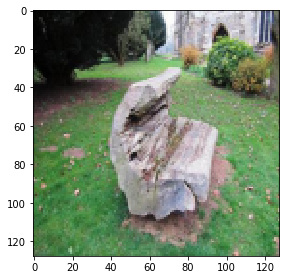

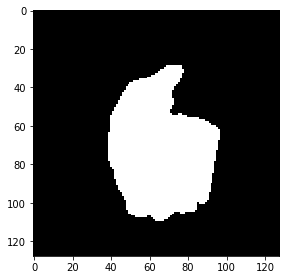

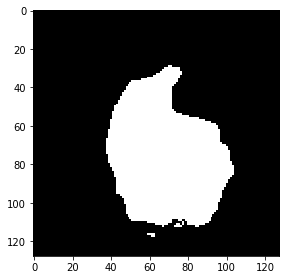

In [ ]:
 
preds_train_t = (preds_train > 0.5).astype(np.bool)
preds_val_t = (preds_val > 0.5).astype(np.bool)
preds_test_t = (preds_test > 0.5).astype(np.bool)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))

display=np.zeros((128,128),dtype=np.uint8)
image=y_train[ix][:,:,0]
for i in range(128):
  for j in range(128):
    if image[i][j]== False:
      display[i][j]=0
    else:
      display[i][j]=255
      
imshow(x_train[ix])
plt.show()



imshow(display)
plt.show()


display2=np.zeros((128,128),dtype=np.uint8)
image2=preds_train_t[ix][:,:,0]
for i in range(128):
  for j in range(128):
    if image2[i][j]== False:
      display2[i][j]=0
    else:
      display2[i][j]=255
imshow(display2)
plt.show()

      



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_

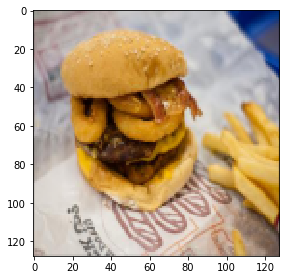

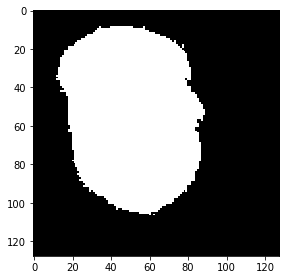

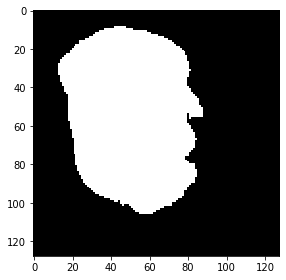

In [ ]:
 
preds_train_t = (preds_train > 0.5).astype(np.bool)
preds_val_t = (preds_val > 0.5).astype(np.bool)
preds_test_t = (preds_test > 0.5).astype(np.bool)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))

display=np.zeros((128,128),dtype=np.uint8)
image=y_train[ix][:,:,0]
for i in range(128):
  for j in range(128):
    if image[i][j]== False:
      display[i][j]=0
    else:
      display[i][j]=255
      
imshow(x_train[ix])
plt.show()



imshow(display)
plt.show()


display2=np.zeros((128,128),dtype=np.uint8)
image2=preds_train_t[ix][:,:,0]
for i in range(128):
  for j in range(128):
    if image2[i][j]== False:
      display2[i][j]=0
    else:
      display2[i][j]=255
imshow(display2)
plt.show()

      



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_

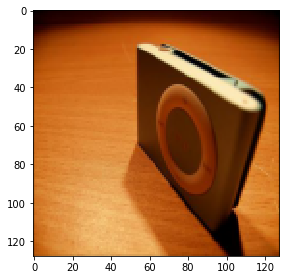

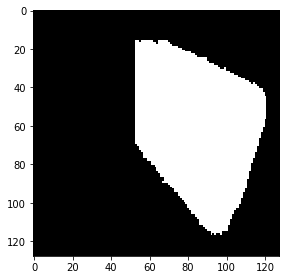

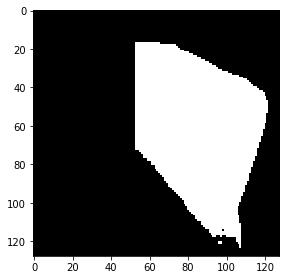

In [ ]:
 
preds_train_t = (preds_train > 0.5).astype(np.bool)
preds_val_t = (preds_val > 0.5).astype(np.bool)
preds_test_t = (preds_test > 0.5).astype(np.bool)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))

display=np.zeros((128,128),dtype=np.uint8)
image=y_train[ix][:,:,0]
for i in range(128):
  for j in range(128):
    if image[i][j]== False:
      display[i][j]=0
    else:
      display[i][j]=255
      
imshow(x_train[ix])
plt.show()



imshow(display)
plt.show()


display2=np.zeros((128,128),dtype=np.uint8)
image2=preds_train_t[ix][:,:,0]
for i in range(128):
  for j in range(128):
    if image2[i][j]== False:
      display2[i][j]=0
    else:
      display2[i][j]=255
imshow(display2)
plt.show()

      



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_

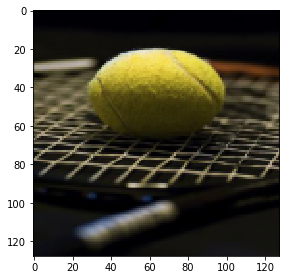

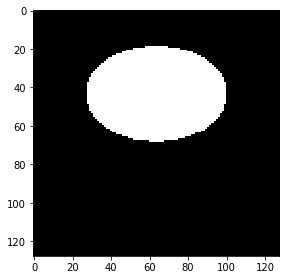

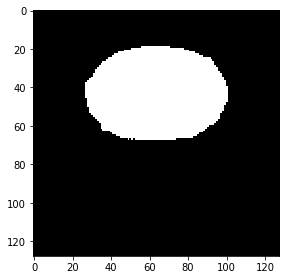

In [ ]:
 
preds_train_t = (preds_train > 0.5).astype(np.bool)
preds_val_t = (preds_val > 0.5).astype(np.bool)
preds_test_t = (preds_test > 0.5).astype(np.bool)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))

display=np.zeros((128,128),dtype=np.uint8)
image=y_train[ix][:,:,0]
for i in range(128):
  for j in range(128):
    if image[i][j]== False:
      display[i][j]=0
    else:
      display[i][j]=255
      
imshow(x_train[ix])
plt.show()



imshow(display)
plt.show()


display2=np.zeros((128,128),dtype=np.uint8)
image2=preds_train_t[ix][:,:,0]
for i in range(128):
  for j in range(128):
    if image2[i][j]== False:
      display2[i][j]=0
    else:
      display2[i][j]=255
imshow(display2)
plt.show()

      



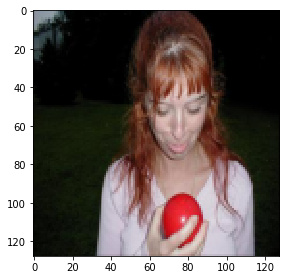

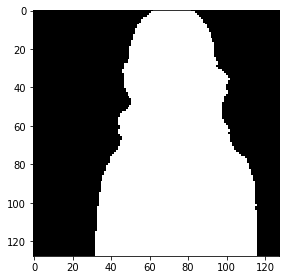

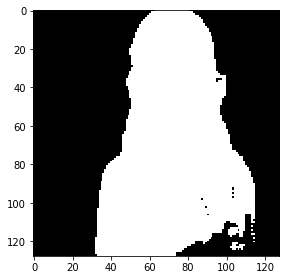

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_test_t))

display=np.zeros((128,128),dtype=np.uint8)
image=y_test[ix][:,:,0]
for i in range(128):
  for j in range(128):
    if image[i][j]== False:
      display[i][j]=0
    else:
      display[i][j]=255
      
imshow(x_test[ix])
plt.show()



imshow(display)
plt.show()


display2=np.zeros((128,128),dtype=np.uint8)
image2=preds_test_t[ix][:,:,0]
for i in range(128):
  for j in range(128):
    if image2[i][j]== False:
      display2[i][j]=0
    else:
      display2[i][j]=255
imshow(display2)
plt.show()

      

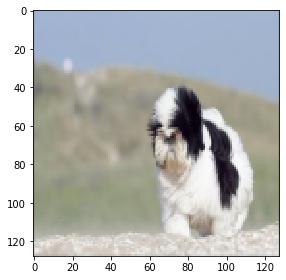

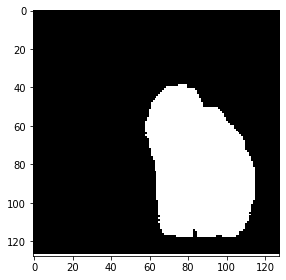

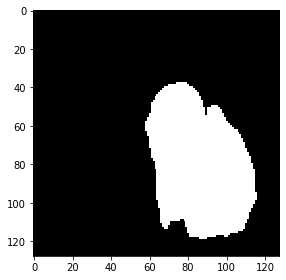

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_test_t))

display=np.zeros((128,128),dtype=np.uint8)
image=y_test[ix][:,:,0]
for i in range(128):
  for j in range(128):
    if image[i][j]== False:
      display[i][j]=0
    else:
      display[i][j]=255
      
imshow(x_test[ix])
plt.show()



imshow(display)
plt.show()


display2=np.zeros((128,128),dtype=np.uint8)
image2=preds_test_t[ix][:,:,0]
for i in range(128):
  for j in range(128):
    if image2[i][j]== False:
      display2[i][j]=0
    else:
      display2[i][j]=255
imshow(display2)
plt.show()

      

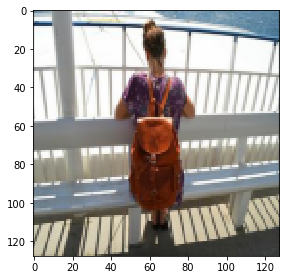

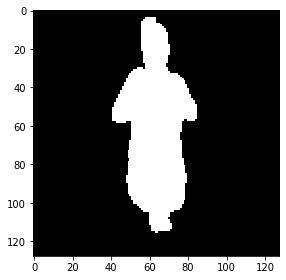

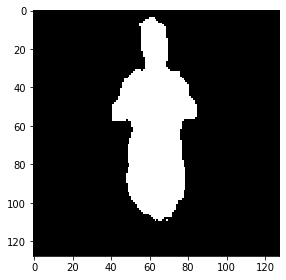

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_test_t))

display=np.zeros((128,128),dtype=np.uint8)
image=y_test[ix][:,:,0]
for i in range(128):
  for j in range(128):
    if image[i][j]== False:
      display[i][j]=0
    else:
      display[i][j]=255
      
imshow(x_test[ix])
plt.show()



imshow(display)
plt.show()


display2=np.zeros((128,128),dtype=np.uint8)
image2=preds_test_t[ix][:,:,0]
for i in range(128):
  for j in range(128):
    if image2[i][j]== False:
      display2[i][j]=0
    else:
      display2[i][j]=255
imshow(display2)
plt.show()

      